In [62]:
# importing packages
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import xgboost
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# PRE PROCESSING FROM CLEANSED DATA FILE

In [3]:
# import cleansed data
file_path = Path("Data/churn_data.csv")

In [5]:
# Create a DataFrame
churn_data_df = pd.read_csv(file_path)
churn_data_df.head(5)

,city,zip,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Los Angeles,90003,Male,No,No,No,2,Yes,No,DSL,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,Female,No,No,Yes,2,Yes,No,Fiber optic,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,Female,No,No,Yes,8,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1
3,Los Angeles,90010,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,Male,No,No,Yes,49,Yes,Yes,Fiber optic,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,1


In [6]:
# View of data set
churn_data_df.describe()

,zip,tenure,monthly_charges,total_charges,churn
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,93523.032565,32.421786,64.798208,2283.300441,0.265785
std,1865.515958,24.545260,30.085974,2266.771362,0.441782
min,90001.000000,1.000000,18.250000,18.800000,0.000000
25%,92102.000000,9.000000,35.587500,401.450000,0.000000
50%,93552.500000,29.000000,70.350000,1397.475000,0.000000
75%,95354.000000,55.000000,89.862500,3794.737500,1.000000
max,96161.000000,72.000000,118.750000,8684.800000,1.000000


In [9]:
# Encode all the categorical data
categorical_cols = ['city', 'gender', 'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service',
                   'online_security', 'online_backup','device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
                    'contract', 'paperless_billing', 'payment_method']
encoders = {}

for i in categorical_cols:
    encoders[i] = LabelEncoder()
    churn_data_df[i] = encoders[i].fit_transform(churn_data_df[i])

churn_data_df.head()

,city,zip,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,562,90003,1,0,0,0,2,1,0,0,...,0,0,0,0,0,1,3,53.85,108.15,1
1,562,90005,0,0,0,1,2,1,0,1,...,0,0,0,0,0,1,2,70.70,151.65,1
2,562,90006,0,0,0,1,8,1,2,1,...,2,0,2,2,0,1,2,99.65,820.50,1
3,562,90010,0,0,1,1,28,1,2,1,...,2,2,2,2,0,1,2,104.80,3046.05,1
4,562,90015,1,0,0,1,49,1,2,1,...,2,0,2,2,0,1,0,103.70,5036.30,1


In [11]:
# Split the data into X and y features
X = churn_data_df.iloc[:, :-1]
y = churn_data_df.iloc[:, -1]

In [16]:
X.describe()

,city,zip,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,...,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,593.711889,93523.032565,0.504693,0.162400,0.482509,0.230375,32.421786,0.903299,0.940557,0.872582,...,0.905859,0.903868,0.796359,0.984926,0.992890,0.688567,0.592719,1.573237,64.798208,2283.300441
std,314.937096,1865.515958,0.500014,0.368844,0.499729,0.421103,24.545260,0.295571,0.948627,0.737271,...,0.880394,0.880178,0.861674,0.885285,0.885385,0.832934,0.491363,1.067504,30.085974,2266.771362
min,0.000000,90001.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000
25%,337.000000,92102.000000,0.000000,0.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,35.587500,401.450000
50%,601.000000,93552.500000,1.000000,0.000000,0.000000,0.000000,29.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,2.000000,70.350000,1397.475000
75%,869.000000,95354.000000,1.000000,0.000000,1.000000,0.000000,55.000000,1.000000,2.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,2.000000,89.862500,3794.737500
max,1128.000000,96161.000000,1.000000,1.000000,1.000000,1.000000,72.000000,1.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,118.750000,8684.800000


In [12]:
# Checking the balance of the Target values- Data is imbalanced.
y.value_counts()

0    5163
1    1869
Name: churn, dtype: int64

In [13]:
# Creating Train and Test split for X and y- 80 to 20 split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True, 
                                                    random_state=1)

In [25]:
# Creating standard scaler instance and fit the training data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

In [26]:
# Scaling Train and Test data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# SIMPLE LOGISTIC REGRESSION CLASSIFIER

In [38]:
lr_clf = LogisticRegression(solver='lbfgs', random_state=1)
lr_clf.fit(X_train_scaled, y_train) 

LogisticRegression()

In [40]:
# Calculate the balanced accuracy score i.e. make predictions/calculate accuracy. Looks good in this instance.
y_pred = lr_clf.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7289498580889309

In [85]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[763, 294],
       [ 73, 277]], dtype=int64)

<AxesSubplot:>

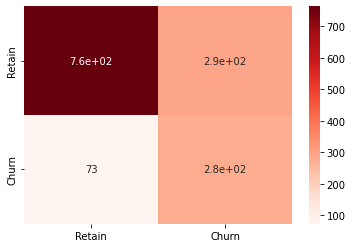

In [86]:
lr_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(lr_clf_cm, annot=True, cmap='Reds')

In [30]:
# Print the imbalanced classification report- based on below results model is performing well.
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.86      0.89      0.57      0.87      0.71      0.52      1057
          1       0.62      0.57      0.89      0.60      0.71      0.49       350

avg / total       0.80      0.81      0.65      0.81      0.71      0.51      1407



In [43]:
# ROC-AUC score
roc_auc_score(y_test, y_pred)

0.728949858088931

# Review results

Since the precision for predicting churn rate and recall is low, there is potentrial to improve this model.

# Combination (Over and Under) Sampling

In this section, will use a combination over and under sampling algorithm to determine if the results can be improved. Will resample the data using the SMOTEENN algorithm.

In [52]:
# Resample the training data with SMOTEENN as the data is imbalanced
lr_sm = SMOTE(random_state=1)
X_resampled, y_resampled = lr_sm.fit_resample(X_train_scaled, y_train)

# View the count of target classes with Counter
Counter(y_resampled)

Counter({0: 4106, 1: 4106})

In [53]:
# Train the Logistic Regression model using the resampled data
lr_cf_model = LogisticRegression(solver='lbfgs', random_state=1)
lr_cf_model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [54]:
# Calculate the balanced accuracy score
y_pred = lr_cf_model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7546546830652792

In [67]:
y_test.describe()

count    1407.000000
mean        0.248756
std         0.432446
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: churn, dtype: float64

In [84]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[763, 294],
       [ 73, 277]], dtype=int64)

In [ ]:
lr_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(lr_clf_cm, annot=True, cmap='Reds')

In [57]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.75      0.76      0.82      0.75      0.57      1057
          1       0.50      0.76      0.75      0.60      0.75      0.57       350

avg / total       0.80      0.75      0.76      0.76      0.75      0.57      1407



In [59]:
# ROC-AUC score
roc_auc_score(y_test, y_pred)

0.7546546830652792

# Review results of resampling with SMOTEEN

Though the false negatives have come down dramatically the false positives is too high.

# Balanced Random Forest Classifier

In [64]:
# Resample the training data with the BalancedRandomForestClassifier
brf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=1)
brf_model = brf_model.fit(X_train_scaled, y_train)

In [65]:
# Calculated the balanced accuracy score
y_pred = brf_model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.762317880794702

In [83]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[763, 294],
       [ 73, 277]], dtype=int64)

<AxesSubplot:>

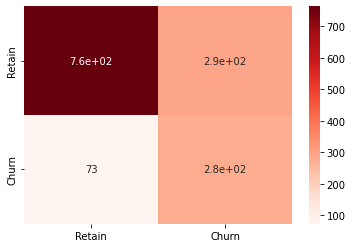

In [79]:
brf_clf_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), index=['Retain', 'Churn'], columns=['Retain', 'Churn'])
sns.heatmap(brf_clf_cm, annot=True, cmap='Reds')

In [71]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.73      0.79      0.81      0.76      0.58      1057
          1       0.50      0.79      0.73      0.61      0.76      0.58       350

avg / total       0.81      0.75      0.78      0.76      0.76      0.58      1407



In [72]:
# List the features sorted in descending order by feature importance
importances = brf_model.feature_importances_
sorted(zip(brf_model.feature_importances_, X.columns), reverse=True)

[(0.12083629897878728, 'tenure'),
 (0.11723298714203481, 'total_charges'),
 (0.11492181490432445, 'monthly_charges'),
 (0.10183008488075136, 'contract'),
 (0.09031020384431102, 'city'),
 (0.08891459315308166, 'zip'),
 (0.05261345539688971, 'tech_support'),
 (0.0480543522679358, 'online_security'),
 (0.04532312212809223, 'dependents'),
 (0.03620741540781331, 'payment_method'),
 (0.029103824114619106, 'internet_service'),
 (0.02381906229311367, 'online_backup'),
 (0.019604805452287308, 'paperless_billing'),
 (0.017766756067248406, 'device_protection'),
 (0.017255352082378522, 'gender'),
 (0.01624114955322387, 'multiple_lines'),
 (0.01570225195084802, 'partner'),
 (0.013539890583595041, 'streaming_tv'),
 (0.012809504783804656, 'senior_citizen'),
 (0.012735438809775537, 'streaming_movies'),
 (0.005177636205084325, 'phone_service')]

# Easy Ensemble Classifier

In [73]:
# Train the Classifier
eec_model = EasyEnsembleClassifier(n_estimators=100, random_state=1)
eec_model.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(n_estimators=100, random_state=1)

In [74]:
# Calculated the balanced accuracy score
y_pred = eec_model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred)

0.7566414380321665

In [75]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred)

array([[763, 294],
       [ 73, 277]], dtype=int64)

In [76]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.91      0.72      0.79      0.81      0.76      0.57      1057
          1       0.49      0.79      0.72      0.60      0.76      0.58       350

avg / total       0.81      0.74      0.77      0.76      0.76      0.57      1407

